In [22]:
import jax
import jax.numpy as jnp
import optax
from jax import random, grad, value_and_grad
from jax import nn
from scipy.stats import norm

import pandas as pd
import numpy as np
import os
import dill

from lib.lib_ARFF import Functions as ARFFFunctions
ARFF_data = np.load("saved_results/param/SPY_ARFF.npz", allow_pickle=True)
ARFF_diff_param = ARFF_data['diff_param'].item()
ARFF_diff_type = ARFF_data['diff_type']

from lib.lib_Adam_tanh import Functions as AdamFunctions
Adam_data = np.load("saved_results/param/SPY_Adam.npz", allow_pickle=True)
Adam_diff_param = Adam_data['diff_param'].item()
Adam_diff_type = Adam_data['diff_type']

print(jax.devices())
print(jnp.sin(jnp.pi/2))

%load_ext autoreload
%autoreload 2

[CudaDevice(id=0)]
1.0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
df = pd.read_csv("training_data/compressed_spy_2020_2022_with_rf.csv")
print(df.head())

   QUOTE_DATE  UNDERLYING_LAST  EXPIRE_DATE     DTE  STRIKE   C_MID  RF_RATE
0  2020-09-09           339.78   2020-10-16   37.00   344.0   7.270   0.0012
1  2022-06-01           409.64   2022-06-15   14.00   396.0  17.050   0.0112
2  2021-10-05           433.06   2021-11-08   34.04   428.0  12.775   0.0004
3  2022-03-04           432.25   2023-12-15  651.00   500.0  20.750   0.0033
4  2022-01-21           438.16   2023-06-16  510.96   370.0  91.570   0.0017


In [23]:
df = df[df['DTE'] > 0].copy()
df['T'] = df['DTE'] / 252  # ensure time to maturity in years

# Convert arrays to JAX
S0 = jnp.array(df['UNDERLYING_LAST'].values)
K = jnp.array(df['STRIKE'].values)
T = jnp.array(df['T'].values)
r = jnp.array(df['RF_RATE'].values)

# Compute sigma from ARFF (vectorized)
S0_jax = S0[:, None]  # shape (N,1)
sigma_jax = ARFFFunctions.diffusion(ARFF_diff_param, S0_jax, ARFF_diff_type) / S0_jax[:, None]
sigma = jnp.squeeze(sigma_jax)  # make it shape (N,)

# Vectorized Black-Scholes call
d1 = (jnp.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * jnp.sqrt(T))
d2 = d1 - sigma * jnp.sqrt(T)
ARFF_BS_prices = S0 * norm.cdf(d1) - K * jnp.exp(-r * T) * norm.cdf(d2)

# Compute sigma from ARFF (vectorized)
S0_jax = S0[:, None]  # shape (N,1)
sigma_jax = AdamFunctions.diffusion(Adam_diff_param, S0_jax, Adam_diff_type) / S0_jax[:, None]
sigma = jnp.squeeze(sigma_jax)  # make it shape (N,)

# Vectorized Black-Scholes call
d1 = (jnp.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * jnp.sqrt(T))
d2 = d1 - sigma * jnp.sqrt(T)
Adam_BS_prices = S0 * norm.cdf(d1) - K * jnp.exp(-r * T) * norm.cdf(d2)

68.71032397481902


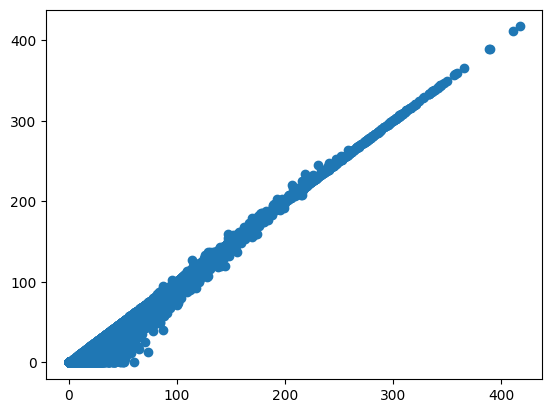

In [31]:
import matplotlib.pyplot as plt

plt.scatter(df['C_MID'].values, ARFF_BS_prices)
print(jnp.mean((df['C_MID'].values - ARFF_BS_prices)**2))

68.98089465073113


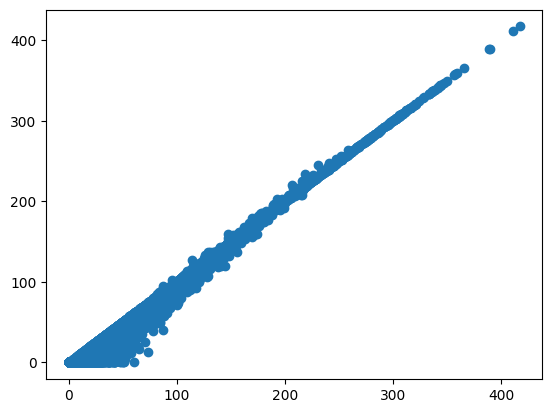

In [32]:
plt.scatter(df['C_MID'].values, Adam_BS_prices)
print(jnp.mean((df['C_MID'].values - Adam_BS_prices)**2))